In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 255
CHANNEL = 3
EPOCHS = 10

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
directory='PlantVillage',
seed=123,
shuffle = True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names
len(class_names)

3

In [8]:
for image_batch,label_batch in dataset.take(1):
    print("Image Batch Shape : ", image_batch.shape)
    # print("Single Image : ", image_batch[0])
    print("Label Image numpy : ", label_batch.numpy)

Image Batch Shape :  (32, 255, 255, 3)
Label Image numpy :  <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 2, 1, 0, 1, 1, 1, 0, 0, 0])>>


In [10]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

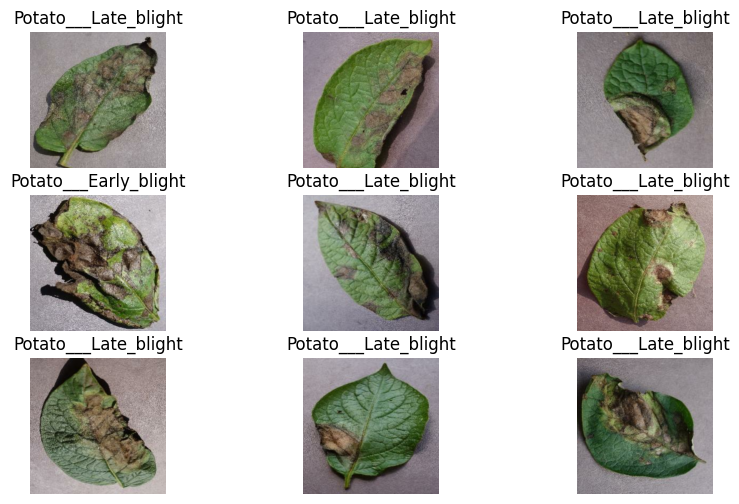

In [13]:
#take a look at how images look
plt.figure(figsize=(10, 6))
for image_batch, labels_batch in dataset.take(1):
    # Code to process the first batch of images and labels
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [14]:
#divide dataset 
len(dataset)

68

In [16]:
# train_size = 0.8
# len(dataset) * train_size #54.40. So  I ma going to take 54 in my train dataset
train_ds = dataset.take(54)
len(train_ds)

54

In [17]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [18]:
# val_size = 0.1
val_ds = test_ds.take(6)
len(val_ds)

6

In [19]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [20]:
# Writing a function for splitting
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
# Cache, shuffle and prefetch datasets for better performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
#to normalize and resize data
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [23]:
#data augmentation for invreasing the size of data for better accuracy
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
#apply augmentation to train set
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
#model building
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 255, 255, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 253, 253, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 126, 126, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 124, 124, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [27]:
# We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10


54/54 [==============================] - 59s 971ms/step - loss: 0.9087 - accuracy: 0.4850 - val_loss: 0.8904 - val_accuracy: 0.5000
Epoch 2/10
54/54 [==============================] - 49s 903ms/step - loss: 0.6480 - accuracy: 0.7193 - val_loss: 0.4808 - val_accuracy: 0.7812
Epoch 3/10
54/54 [==============================] - 44s 820ms/step - loss: 0.3445 - accuracy: 0.8553 - val_loss: 0.6178 - val_accuracy: 0.7552
Epoch 4/10
54/54 [==============================] - 44s 814ms/step - loss: 0.3779 - accuracy: 0.8536 - val_loss: 0.2981 - val_accuracy: 0.8802
Epoch 5/10
54/54 [==============================] - 44s 816ms/step - loss: 0.2050 - accuracy: 0.9253 - val_loss: 0.2277 - val_accuracy: 0.8854
Epoch 6/10
54/54 [==============================] - 1439s 27s/step - loss: 0.1949 - accuracy: 0.9259 - val_loss: 0.1505 - val_accuracy: 0.9427
Epoch 7/10
54/54 [==============================] - 45s 827ms/step - loss: 0.1402 - accuracy: 0.9485 - val_loss: 0.1101 - val_accuracy: 0.95

In [29]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 267ms/step - loss: 0.0569 - accuracy: 0.9766


In [30]:
#save the model
model.save("model.h5")

c:\Users\REDMI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
#Doing predictions for sample
model = tf.keras.models.load_model('model.h5')

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 404ms/step
predicted label: Potato___Early_blight


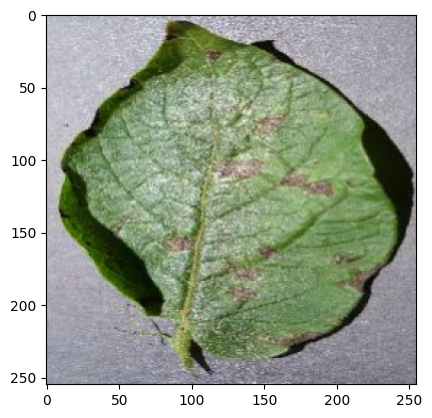

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 26ms/step


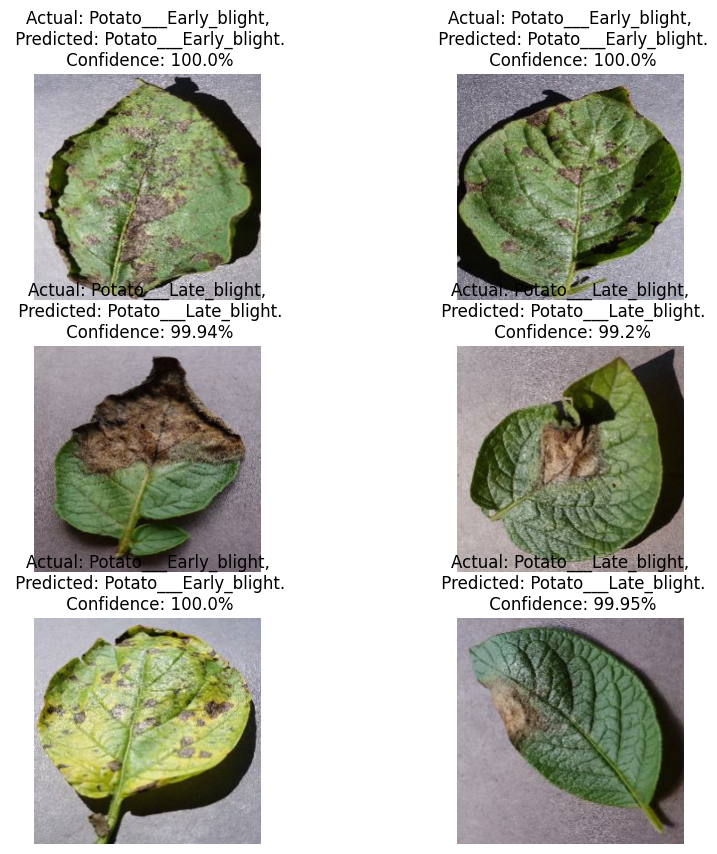

In [35]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [36]:
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 10, 'steps': 54}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

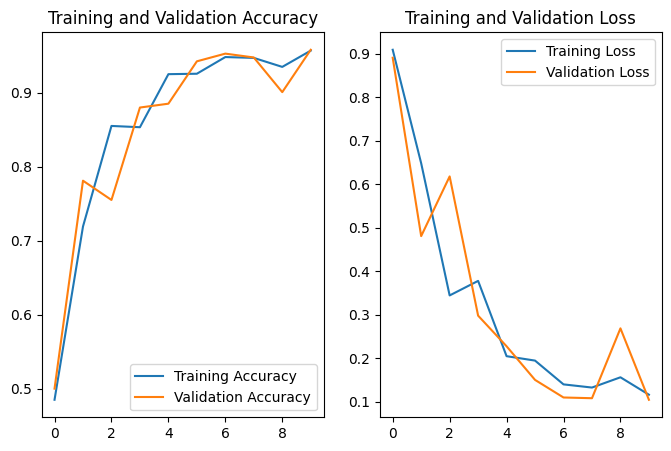

In [39]:
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
tf.__version__

'2.15.0'